### Building an ANN

### Input is MNIST Fashion dataset, to classify fashion articles. 28x28 pictures.

### 4 layers, 1 input layer (784), 2 hidden layers(128 and 64) and 1 output layer (10)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import zipfile
import os

file_path = "/content/archive.zip"
output_dir = "/content/"

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"File extracted to {output_dir}")

File extracted to /content/


In [6]:
df = pd.read_csv("/content/fashion-mnist_train.csv")

In [7]:
df.shape

(60000, 785)

In [ ]:
# df = df.sample(n=6000, random_state=42)

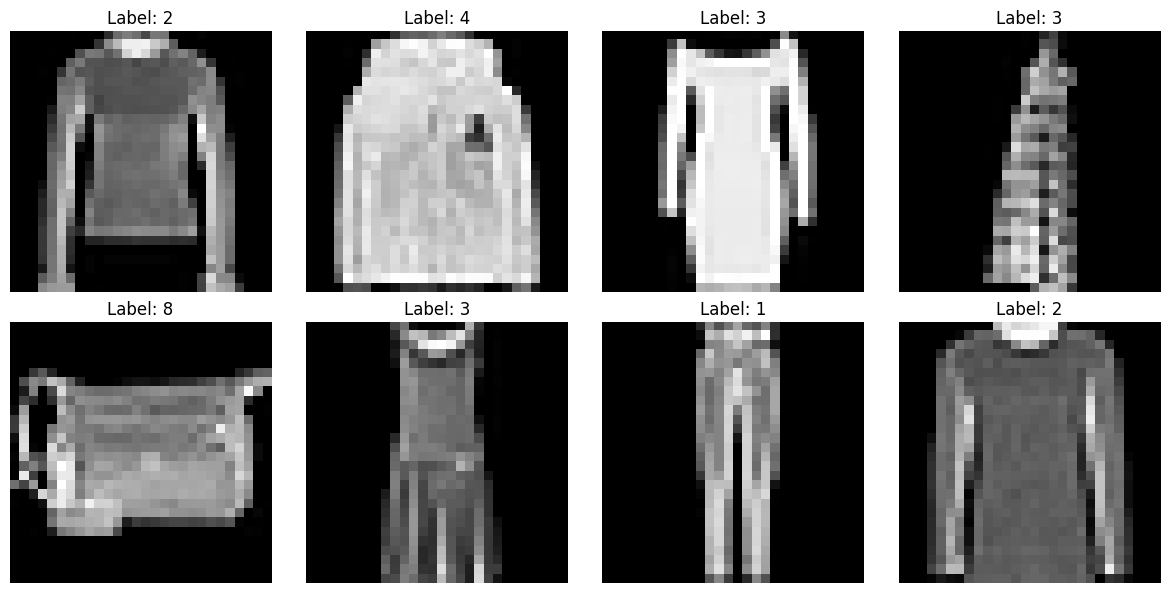

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select 8 random indices
random_indices = np.random.choice(df.index, size=8, replace=False)

# Get the images and labels for the selected indices
random_images = df.loc[random_indices, df.columns != 'label'].values
random_labels = df.loc[random_indices, 'label'].values

# Reshape the images to 28x28
random_images = random_images.reshape(-1, 28, 28)

# Display the images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i], cmap='gray')
    plt.title(f"Label: {random_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
display(df['label'].value_counts().sort_index())

,count
label,
0,6000
1,6000
2,6000
3,6000
4,6000
5,6000
6,6000
7,6000
8,6000


In [10]:
# test train split

x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
# scaling

x_train = x_train/255.0
x_test = x_test/255.0

In [12]:
# create customdataset class

class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [13]:
# create train_dataset object

train_dataset = CustomDataset(x_train, y_train)

In [14]:
len(train_dataset)
train_dataset[1]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [15]:
# create test_dataset object

test_dataset = CustomDataset(x_test, y_test)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
class MyNN(nn.Module):
  def __init__(self, num_features):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(32, 10),
    )

  def forward(self, x):
    return self.model(x)

In [42]:
epochs = 100
learning_rate = 0.01

In [47]:
# instantiate model
model = MyNN(x_train.shape[1])
model.to(device)

# instatntiate loss function
criterion = nn.CrossEntropyLoss()

# opimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 1e-4)

In [44]:
# print number of batches
len(train_loader)

750

In [48]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calcultae loss
    loss = criterion(outputs, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  print(f"Epoch: {epoch+1}, Loss: {total_epoch_loss/len(train_loader)}")

Epoch: 1, Loss: 1.4710889439582824
Epoch: 2, Loss: 0.6916696337461472
Epoch: 3, Loss: 0.5764801483949026
Epoch: 4, Loss: 0.5232226660251618
Epoch: 5, Loss: 0.49265177331368126
Epoch: 6, Loss: 0.4768290747801463
Epoch: 7, Loss: 0.4570746412674586
Epoch: 8, Loss: 0.44428461023171745
Epoch: 9, Loss: 0.43060998926560085
Epoch: 10, Loss: 0.41988450942436856
Epoch: 11, Loss: 0.41369034032026925
Epoch: 12, Loss: 0.4030795825123787
Epoch: 13, Loss: 0.39654575888315835
Epoch: 14, Loss: 0.38900556673606235
Epoch: 15, Loss: 0.38403856203953424
Epoch: 16, Loss: 0.38075136492649714
Epoch: 17, Loss: 0.37305445603529613
Epoch: 18, Loss: 0.3696667167147001
Epoch: 19, Loss: 0.3646942910949389
Epoch: 20, Loss: 0.3615255056619644
Epoch: 21, Loss: 0.35456614470481873
Epoch: 22, Loss: 0.3502897377808889
Epoch: 23, Loss: 0.3464679882923762
Epoch: 24, Loss: 0.34504466263453165
Epoch: 25, Loss: 0.3357517082889875
Epoch: 26, Loss: 0.3360022077957789
Epoch: 27, Loss: 0.33168189856410024
Epoch: 28, Loss: 0.32786

In [49]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [50]:
len(test_loader)

188

In [51]:
# evaluation code

total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(f"Accuracy on test: {correct/total}")

# evaluation on training data

total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(f"Accuracy on train: {correct/total}")

Accuracy on test: 0.8869166666666667
Accuracy on train: 0.9604583333333333
